In [1]:
import numpy as np
import matplotlib.pyplot as plt
import energyflow as ef

In [2]:
# load quark and gluon jets
X, y = ef.qg_jets.load(2000)
num = 750

In [3]:
# the jet radius for these jets
R = 0.4

# process jets
Gs, Qs = [], []
for arr,events in [(Gs, X[y==0]), (Qs, X[y==1])]:
    for i,x in enumerate(events):
        if i >= num:
            break
        
        # ignore padded particles and removed particle id information
        x = x[x[:,0] > 0,:3]

#         center jet according to pt-centroid
        yphi_avg = np.average(x[:,1:3], weights=x[:,0], axis=0)
        x[:,1:3] -= yphi_avg

#         mask out any particles farther than R=0.4 away from center (rare)
        x = x[np.linalg.norm(x[:,1:3], axis=1) <= R]
        
        # add to list
        arr.append(x)

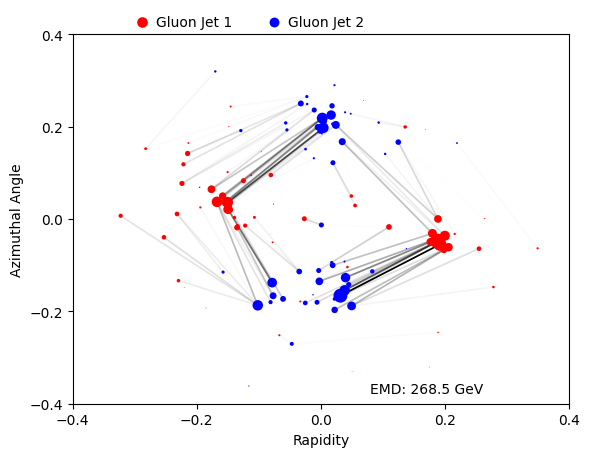

In [4]:
# choose interesting events
ev0, ev1 = Gs[0], Gs[15]

# calculate the EMD and the optimal transport flow
R = 0.4
emdval, G = ef.emd.emd(ev0, ev1, R=R, return_flow=True)

# plot the two events
colors = ['red', 'blue']
labels = ['Gluon Jet 1', 'Gluon Jet 2']
for i,ev in enumerate([ev0, ev1]):
    pts, ys, phis = ev[:,0], ev[:,1], ev[:,2]
    plt.scatter(ys, phis, marker='o', s=2*pts, color=colors[i], lw=0, zorder=10, label=labels[i])
    
# plot the flow
mx = G.max()
xs, xt = ev0[:,1:3], ev1[:,1:3]
for i in range(xs.shape[0]):
    for j in range(xt.shape[0]):
        if G[i, j] > 0:
            plt.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]],
                     alpha=G[i, j]/mx, lw=1.25, color='black')

# plot settings
plt.xlim(-R, R); plt.ylim(-R, R)
plt.xlabel('Rapidity'); plt.ylabel('Azimuthal Angle')
plt.xticks(np.linspace(-R, R, 5)); plt.yticks(np.linspace(-R, R, 5))

plt.text(0.6, 0.03, 'EMD: {:.1f} GeV'.format(emdval), fontsize=10, transform=plt.gca().transAxes)
plt.legend(loc=(0.1, 1.0), frameon=False, ncol=2, handletextpad=0)

plt.show()

## PFN

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, 4)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 3)      15          ['input[0][0]']                  
                                                                                                  
 activation (Activation)        (None, None, 3)      0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 16)     64          ['activation[0][0]']             
  

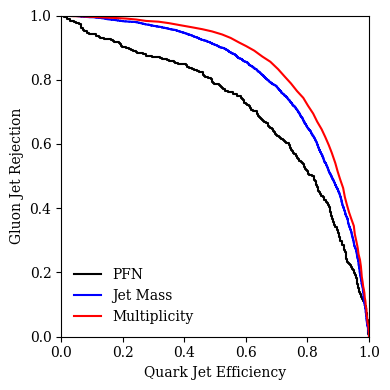

In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 7500, 1000, 1500
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (3, 16), (10,)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 5
batch_size = 500

################################################################################

# load data
X, y = qg_jets.load(train + val + test)

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3, error_on_unknown=False)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('PFN AUC:', auc)
print()

# get multiplicity and mass for comparison
masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

# some nicer plot settings 
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)
plt.show()
